In [1]:
from __future__ import print_function
from firedrake import *
from firedrake_adjoint import *
import numpy as np
import os, sys
import spyro

import numpy as np
import math
import matplotlib.pyplot as plot
import matplotlib.ticker      as mticker  
from matplotlib               import cm
from mpl_toolkits.axes_grid1  import make_axes_locatable
import memory_profiler

model = {}
model["opts"] = {
    "method": "KMV",  # either CG or KMV
    "quadratrue": "KMV",  # Equi or KMV
    "degree": 2,  # p order
    "dimension": 2,  # dimension
}
model["parallelism"] = {
    "type": "spatial",  # options: automatic (same number of cores for evey processor), custom, off.
    "custom_cores_per_shot": [],  # only if the user wants a different number of cores for every shot.
    "num_cores_per_shot": 1
}
model["mesh"] = {
    "Lz": 1.,  # depth in km - always positive
    "Lx": 1.,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "meshfile": "meshes/square.msh",
    "initmodel": "not_used.hdf5",
    "truemodel": "velocity_models/MarmousiII_w1KM_EXT_GUESS.hdf5",
}
model["BCs"] = {
    "status": False,  # True or false
    "outer_bc": "non-reflective",  #  None or non-reflective (outer boundary condition)
    "damping_type": "polynomial",  # polynomial, hyperbolic, shifted_hyperbolic
    "exponent": 2,  # damping layer has a exponent variation
    "cmax": 3.,  # maximum acoustic wave velocity in PML - km/s
    "R": 1e-6,  # theoretical reflection coefficient
    "lz": 0.9,  # thickness of the PML in the z-direction (km) - always positive
    "lx": 0.9,  # thickness of the PML in the x-direction (km) - always positive
    "ly": 0.0,  # thickness of the PML in the y-direction (km) - always positive
}
model["acquisition"] = {
    "source_type": "Ricker",
    "num_sources": 1,
    "source_pos": spyro.create_transect((-0.1, 0.1), (-0.1, 0.9), 2),
    "frequency": 4.0,
    "delay": 1.0,
    "num_receivers": 100,
    "receiver_locations": spyro.create_transect((-0.10, 0.1), (-0.10, 0.9), 100),
}
model["timeaxis"] = {
    "t0": 0.0,  #  Initial time for event
    "tf": 1.00,  # Final time for event
    "dt": 0.001,
    "amplitude": 1,  # the Ricker has an amplitude of 1.
    "nspool": 100,  # how frequently to output solution to pvds
    "fspool": 99999,  # how frequently to save solution to RAM
}

num_rec = model["acquisition"]["num_receivers"]
δs = np.linspace(0.1, 0.9, num_rec)
X, Y = np.meshgrid(-0.1, δs)
xs = np.vstack((X.flatten(), Y.flatten())).T


In [2]:
comm    = spyro.utils.mpi_init(model)
mesh, V = spyro.io.read_mesh(model, comm)

x, y = SpatialCoordinate(mesh)
velocity = conditional(x > -0.5, 1.5, 1.5)
vp   = Function(V, name="vp").interpolate(velocity)



INFO: Distributing 1 shot(s) across 1 core(s). Each shot is using 1 cores
  rank 0 on ensemble 0 owns 780 elements and can access 431 vertices


In [3]:
sources = spyro.Sources(model, mesh, V, comm)
tf   = model["timeaxis"]["tf"] 
dt   = model["timeaxis"]["dt"]
freq = model["acquisition"]["frequency"]

wavelet = spyro.full_ricker_wavelet(dt=dt, tf=tf, freq=freq)


In [4]:
control = Control(vp)

usol_rec = []
dJdm = Function(V)
J_total =0
usol_rec = []
for sn in range(0,model["acquisition"]["num_sources"]):
    
    p_true_rec = spyro.io.load_shots(model, comm, file_name='true_rec/true_rec_' + str(sn))
    solver  = spyro.solver_AD(p_true_rec=p_true_rec,Calc_Jfunctional=True)
    solver.obj_func = 0.
    p_rec  = solver.forward_AD(model, mesh, comm, vp, sources, wavelet, xs, source_num=sn)
    J = solver.obj_func
    J_total += J
    print(J)
#     dJdm += compute_gradient(J, control)
    
    usol_rec.append(p_rec)



Simulation time is:        0.0 seconds
Simulation time is:      0.099 seconds
Simulation time is:      0.199 seconds
Simulation time is:      0.299 seconds
Simulation time is:      0.399 seconds
Simulation time is:      0.499 seconds
Simulation time is:      0.599 seconds
Simulation time is:      0.699 seconds
Simulation time is:      0.799 seconds
Simulation time is:      0.899 seconds
---------------------------------------------------------------
2.698394425751284e-05


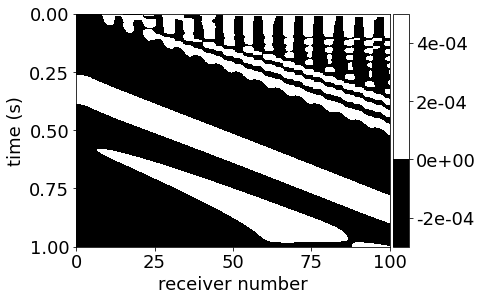

In [5]:
spyro.plots.plot_shots(
            model,comm,p_rec,show=True,file_name=str(0 + 1),legend=True,save=False
        )



In [9]:
# fig, axes = plot.subplots()
# axes.set_aspect('equal')
# colors = firedrake.tripcolor(dJdm, axes=axes, shading='gouraud', cmap="jet")

# fig.colorbar(colors);
# plot.savefig('grad.png',dpi=100,format='png')


In [7]:
h = Function(V)
h.vector()[:] = 0.1
Jhat    = ReducedFunctional(J_total, control) 
conv_rate = taylor_test(Jhat, vp, h)

Running Taylor test
Computed residuals: [1.9436920524834205e-10, 4.8623133061002814e-11, 1.2159629924952688e-11, 3.0403881149272475e-12]
Computed convergence rates: [1.9990849022474033, 1.9995435358734048, 1.999771916404329]


In [8]:
water = np.where(vp.dat.data[:] < 1.51)
dJdm.dat.data[water] = 0.0
File("grad_ad.pvd").write(dJdm)
File("vel.pvd").write(vp)